Imports.

In [1]:
from enum import Enum
from typing import NamedTuple
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, UpSampling2D, ZeroPadding2D, Cropping2D, Conv2DTranspose
from keras.layers.merge import concatenate
import keras
from numba import njit

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Definições, inicializações e funções utilitárias.

In [2]:
#The tolerance for floating pointer comparison
epsilon = 0.000001

#The complexity of the variogram models
numberOfNestedStructures = 4
numberOfParametersPerNestedStructure = 4 #ATTENTION: if you change this value, you must change the makeVariogramModelSurface() function accordingly
totalNumberOfParameters = numberOfNestedStructures * numberOfParametersPerNestedStructure

#The target sill for the variogram models
sill = 0.64

#The range for the longest structure allowed in the variogram models
maxAxis = 50.0

class StructureType(Enum):
    Spheric     = 1
    Exponential = 2
    Gaussian    = 3
    
class EllipsoidParameters(NamedTuple):
    Azimuth      : float
    SemiMajorAxis: float
    SemiMinorAxis: float

class GridParameters(NamedTuple):
    X0: float
    Y0: float
    DX: float
    DY: float
    NI: int
    NJ: int

def getExtent2D( gridParameters : GridParameters ) -> np.array :
    gridCornerX = gridParameters.X0 - gridParameters.DX/2;
    gridCornerY = gridParameters.Y0 - gridParameters.DY/2;
    return [
           gridCornerX,
           gridCornerX + gridParameters.DX*gridParameters.NI,
           gridCornerY,
           gridCornerY + gridParameters.DY*gridParameters.NJ
           ]

def getGridParameters() -> GridParameters :
    return GridParameters( X0=-50., Y0=-50., 
                           DX=1,    DY=1, 
                           NI=100,  NJ=100 )    

Função gera superfície variográfica

In [3]:
@njit
def makeVariographicSurface( structureType       : StructureType, 
                             ellipsoidParameters : EllipsoidParameters, 
                             contribution        : float,
                             gridParameters      : GridParameters ) -> np.array :
   #NOTA VARIAVEIS COM [0] APARENTEMENTE DE FORMA DESNECESSARIA
   #sem isso dá erro de tipo não reconhecido (array) ao tentar usar com o JIT do Numba.
   #
   #Cria o numpy.array seguindo os parâmetros do grid.
   grid = np.zeros(( gridParameters.NI, gridParameters.NJ ));
   #Check for null structure
   if( contribution[0] < epsilon or 
       ellipsoidParameters.SemiMajorAxis[0] < epsilon or 
       ellipsoidParameters.SemiMinorAxis[0] < epsilon ) :
       return grid;
   #Obtem parâmetros geométricos
   a = ellipsoidParameters.SemiMajorAxis;
   b = ellipsoidParameters.SemiMinorAxis;
   c = contribution;                                       #contribution to semivariance
   theta = ellipsoidParameters.Azimuth/180.0 * math.pi; #azimuth
   xc = gridParameters.X0 - gridParameters.DX/2 + gridParameters.DX*gridParameters.NI/2; #center of the grid
   yc = gridParameters.Y0 - gridParameters.DY/2 + gridParameters.DY*gridParameters.NJ/2; #center of the grid
   #Calcula o variograma em cada célula do grid   
   for j in range( gridParameters.NJ ) :
      for i in range( gridParameters.NI ) :
         xCell = gridParameters.X0 + gridParameters.DX * i;
         yCell = gridParameters.Y0 + gridParameters.DY * j;
         x = (xCell - xc) * math.cos(theta[0]) - (yCell - yc) * math.sin(theta[0]);
         y = (xCell - xc) * math.sin(theta[0]) + (yCell - yc) * math.cos(theta[0]);
         modulusSquared = (x/a)*(x/a) + (y/b)*(y/b);
         h = math.sqrt( modulusSquared[0] );
         if( h >= 0. and h <= 1. ) :
            semivariance = c * (3*h/2.-math.pow(h, 3)/2.);
         else :
            semivariance = c;
         grid[i,j] = semivariance[0];
   #retorna o grid
   return grid;

Função para gerar a superfície de um modelo variográfico de 4 estruturas

In [4]:
# The parameters must be a linear 16-element array of floats in the following order:
# azimuth, semi-major axis, semi-minor axis, contribution, azimuth, ...
# for four structures.  Models with less than for structures can be specified with all-zero parameters
def makeVariogramModelSurface( parameters : np.array ) -> np.array :
    gridParameters = getGridParameters()
    variogramModelSurface = np.zeros(( gridParameters.NI, gridParameters.NJ ));
    for i in range( numberOfNestedStructures ) :
        variogramModelSurface += \
            makeVariographicSurface( structureType = StructureType.Spheric, 
                                     ellipsoidParameters = EllipsoidParameters( Azimuth      =parameters[i*numberOfParametersPerNestedStructure+0], 
                                                                                SemiMajorAxis=parameters[i*numberOfParametersPerNestedStructure+1], 
                                                                                SemiMinorAxis=parameters[i*numberOfParametersPerNestedStructure+2] ), 
                                     contribution=parameters[i*numberOfParametersPerNestedStructure+3],
                                     gridParameters = gridParameters )
    return variogramModelSurface;


Programa

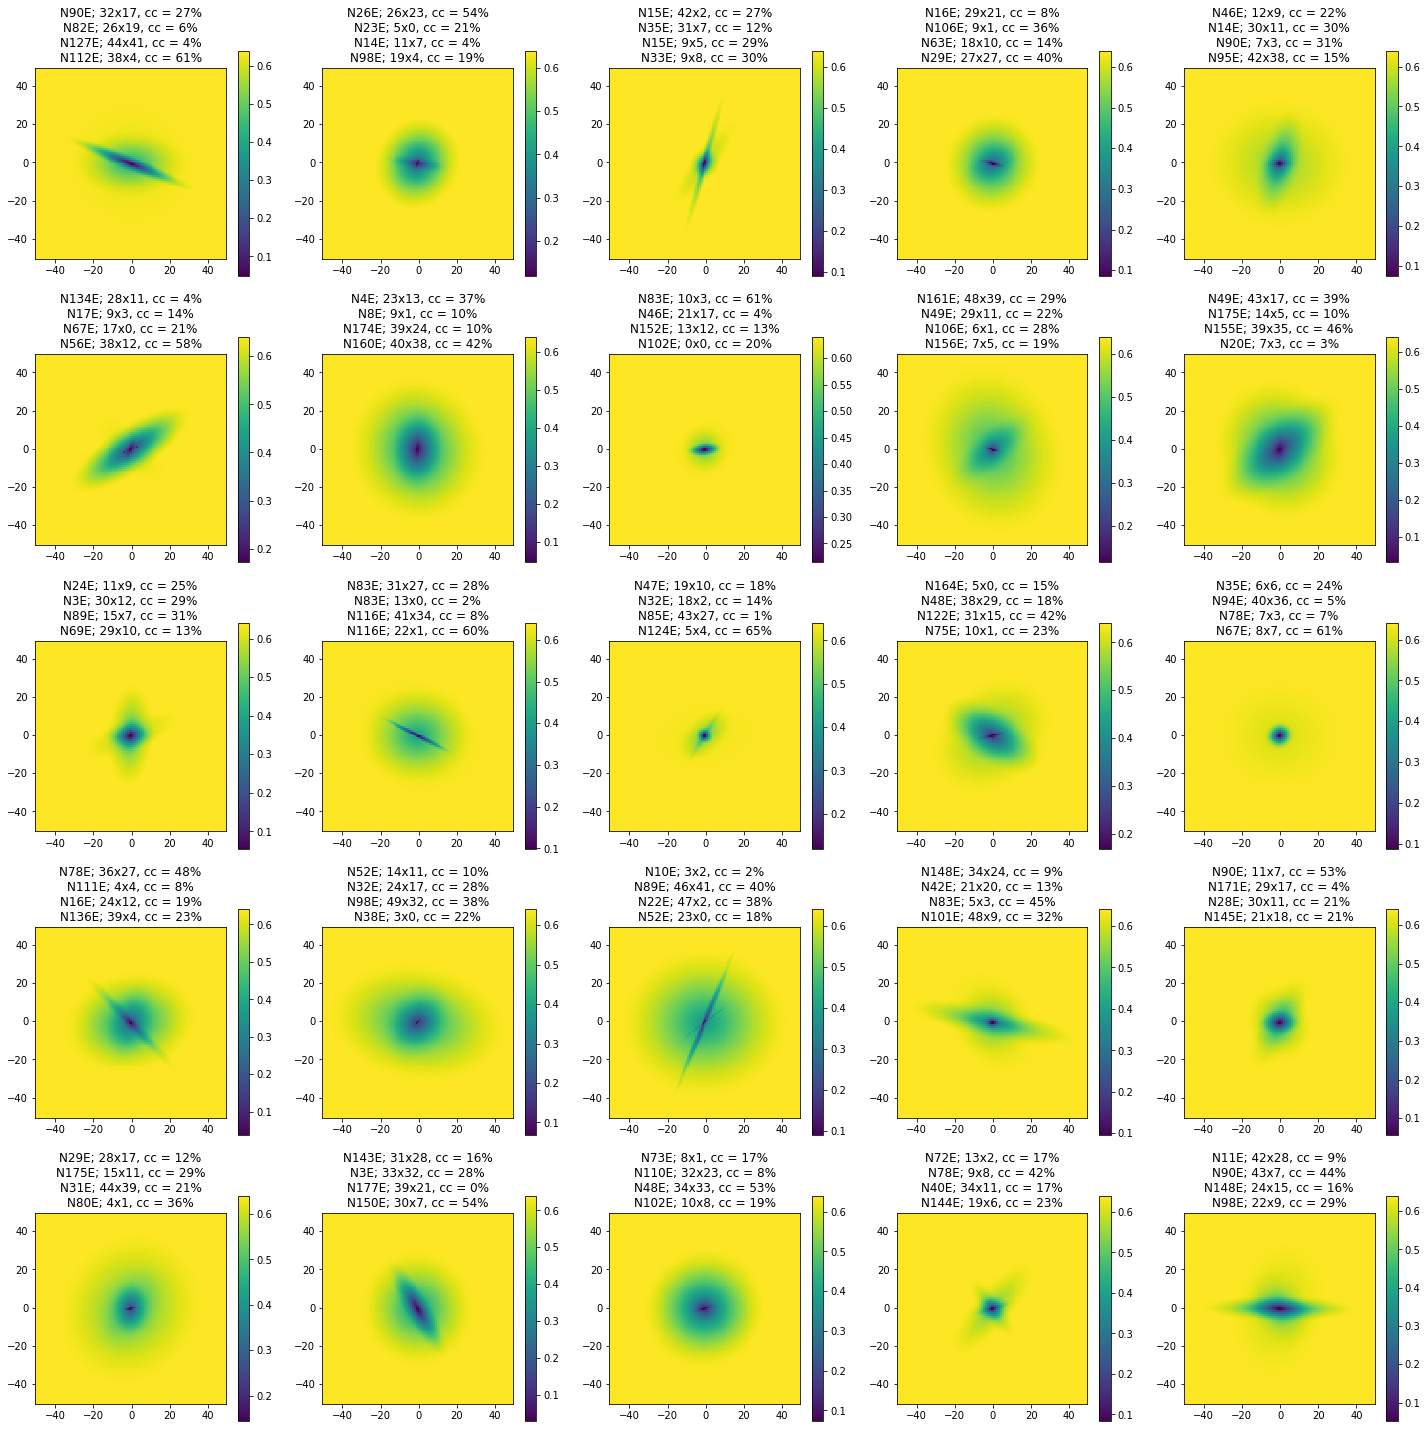

In [5]:
#The number of random variogram surfaces to generate
n = 40

#Allocate a volume for the stack of all variogram model surfaces n * 100 * 100
allVariograms = np.zeros(( n, getGridParameters().NI, getGridParameters().NJ))

#Allocate the stack of variographic parameters n * 16 * 1
allParameters = np.zeros(( n, totalNumberOfParameters, 1))

#Generate the variogram surfaces for training
for iVariogram in range(n):
    
    #Radomize the azimuths (N000E through N180E)
    az = np.random.rand(numberOfNestedStructures, 1)
    
    #Randomize the semi-major axes
    a = np.random.rand(numberOfNestedStructures, 1)

    #Randomize the semi-minor axes such that they are necessarily smaller than the semi-major axes
    b = np.multiply( a, np.random.rand(numberOfNestedStructures, 1) )
    
    #Randomize the contributions such that they sum up to a total (variogram sill)
    cc = np.random.rand(numberOfNestedStructures, 1) 
    cc = cc / np.sum(cc)
    
    #Linearize the array of variographic parameters
    linearArrayOfParametersUnitized = np.column_stack( (az, a, b, cc) ).reshape(totalNumberOfParameters,1)
    linearArrayOfParametersFullScale = np.column_stack( (az * 180, a*maxAxis, b*maxAxis, cc*sill) ).reshape(totalNumberOfParameters,1)
    
    #Make variogram surface
    variogramModelSurface = makeVariogramModelSurface( linearArrayOfParametersFullScale );
    
    #Stack the variogram surface
    allVariograms[iVariogram,:,:] = variogramModelSurface
    
    #Stack the linearized variographic parameters
    allParameters[iVariogram,:,:] = linearArrayOfParametersUnitized


#Prepare a plot area measuring 5 by 5 figures, each measuring 20x20
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

#Plot the first 25 variogram surfaces to check data
iMap = int(0)
for ax in axs.flat:

    #plot the variogram surface
    mappable = ax.imshow( allVariograms[iMap,:,:], 
                    interpolation='none',
                    extent=getExtent2D( getGridParameters() ))
    fig.colorbar(mappable, ax=ax)
    ax.set_title( "N" + str(int(allParameters[iMap,0,0]*180)) + "E; " 
                      + str(int(allParameters[iMap,1,0]*maxAxis)) + "x"
                      + str(int(allParameters[iMap,2,0]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iMap,3,0])) + "%\n" + 
                  "N" + str(int(allParameters[iMap,4,0]*180)) + "E; " 
                      + str(int(allParameters[iMap,5,0]*maxAxis)) + "x"
                      + str(int(allParameters[iMap,6,0]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iMap,7,0])) + "%\n" + 
                  "N" + str(int(allParameters[iMap,8,0]*180)) + "E; " 
                      + str(int(allParameters[iMap,9,0]*maxAxis)) + "x"
                      + str(int(allParameters[iMap,10,0]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iMap,11,0])) + "%\n" + 
                  "N" + str(int(allParameters[iMap,12,0]*180)) + "E; " 
                      + str(int(allParameters[iMap,13,0]*maxAxis)) + "x"
                      + str(int(allParameters[iMap,14,0]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iMap,15,0])) + "%" )
    
    #Increment the synthetic map index/count
    iMap = iMap + 1
    
#Lay out the plots
plt.tight_layout()
plt.show()



Carregar o mapa variográfico experimental

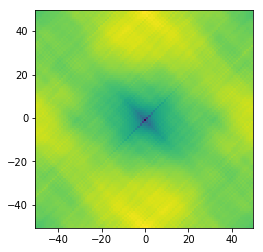

In [6]:
#Load the input experimental variogram map from teh GEO-EAS format (has some headers to skip)
experimentalVarmap = np.loadtxt(fname = "../GR_TESE_ML/value_Varmap.dat", skiprows=4)

#get the desired column (with the experimental semivariances)
experimentalVarmap = experimentalVarmap[:,0]

#reshape to 2D image
experimentalVarmap = experimentalVarmap.reshape(( getGridParameters().NI, getGridParameters().NJ ))

#plot the experimental varmap
plt.imshow( experimentalVarmap, interpolation='none', extent=getExtent2D( getGridParameters() ))

Parte de Machine Learning

In [7]:
#Normalizar os dados de entrada
#normalizer   = StandardScaler()
#X_norm = normalizer.fit_transform(X)
#ver se o normalizer traz para 0.0-1.0 mesmo
#normalizar as superfícies teóricas e o experimental na mesma escala (max de todos os mapas + experimental)
#colocar camadas de max/min pooling depois de cada camada convolutiva
#ver rede LeNet dado em um dos notebooks da aula.

#Dividir o conjunto total de superfícies variográficas e seus parâmetros em dois conjuntos:
#  1) O conjunto de treinamento, para o processamento do backpropagation.
#  2) O conjunto de teste, para aferição de métricas de acurácia da predição
trainVariograms, testVariograms, trainParameters, testParameters = \
      train_test_split(allVariograms, allParameters, test_size=0.25, random_state=11111)
    
#Talvez tenha que rescalar os variogramas para 0.0-1.0

#Compatibiliza os dados de entrada para uso no Keras, que espera tensores (matrizes de ordem maior que 2)
#de ordem 4: # de imagens, dimensão I de cada imagem, dimensão J de cada imagem, # de canais em cada imagem
trainVariograms = trainVariograms.reshape(trainVariograms.shape + (1,)) #(1,) significa uma tupla de um elemento
testVariograms  = testVariograms.reshape(testVariograms.shape + (1,))

#Cria a parte convolutiva da arquitetura de rede
input_layer = Input(shape=(getGridParameters().NI, getGridParameters().NJ, 1))
zp = ZeroPadding2D(padding=((14,14),(14,14))) ( input_layer )
conv1 = Conv2D(10, kernel_size=3, activation='relu', padding='same') ( zp ) #camada convolutiva de 10 kernels (corresponde a 10 neurônios)
mp1 = MaxPooling2D(pool_size=(2, 2), padding='same') ( conv1 )
conv2 = Conv2D(20, kernel_size=3, activation='relu', padding='same') ( mp1 ) #camada convolutiva de 20 kernels (corresponde a 20 neurônios)
mp2 = MaxPooling2D(pool_size=(2, 2), padding='same') ( conv2 )
conv3 = Conv2D(40, kernel_size=3, activation='relu', padding='same') ( mp2 ) #camada convolutiva de 40 kernels (corresponde a 40 neurônios)
mp3 = MaxPooling2D(pool_size=(2, 2), padding='same') ( conv3 )
conv4 = Conv2D(80, kernel_size=3, activation='relu', padding='same') ( mp3 ) #camada convolutiva de 40 kernels (corresponde a 40 neurônios)
mp4 = MaxPooling2D(pool_size=(2, 2)) ( conv4 )

#O eixo central da rede U
conv99 = Conv2D(160, kernel_size=3, activation='relu', padding='same') ( mp4 ) #camada convolutiva de 80 kernels (corresponde a 80 neurônios)

#Cria a parte deconvolutiva da arquitetura de rede
up4 = Conv2DTranspose(80, (3, 3), strides=(2, 2), padding='same') ( conv99 )
up4 = concatenate([up4, conv4])  # <------------------------------------------informação vindo lá da camada conv.4
dconv4 = Conv2D(80, kernel_size=3, activation='relu', padding='same') ( up4 )
up3 = Conv2DTranspose(40, (3, 3), strides=(2, 2), padding='same') ( dconv4 )
up3 = concatenate([up3, conv3])  # <------------------------------------------informação vindo lá da camada conv.3
dconv3 = Conv2D(40, kernel_size=3, activation='relu', padding='same') ( up3 )
up2 = Conv2DTranspose(20, (3, 3), strides=(2, 2), padding='same') ( dconv3 )
up2 = concatenate([up2, conv2])  # <------------------------------------------informação vindo lá da camada conv.2
dconv2 = Conv2D(20, kernel_size=3, activation='relu', padding='same') ( up2 )
up1 = Conv2DTranspose(10, (3, 3), strides=(2, 2), padding='same') ( dconv2 )
up1 = concatenate([up1, conv1])  # <------------------------------------------informação vindo lá da camada conv.1
dconv1 = Conv2D(10, kernel_size=3, activation='relu', padding='same') ( up1 )

decoder = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same') ( dconv1 ) 
decoder = Cropping2D(cropping=((14,14),(14,14))) ( decoder )

#Monta a arquitetura autoencoder U completa
autoencoder = Model(input_layer, decoder)

#Mostra o resumo da arquitetura
autoencoder.summary()




Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 10) 100         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 10)   0           conv2d_1[0][0]                   
_____________________________________

In [8]:
#compila o modelo, passando o algoritmo de otimização, a métrica para a função-objetivo e a métrica para aferir a acurácia
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') #metrics=["accuracy"] não ajuda para regressões

#treina a rede
#25% do dado de entrada serão usados como conjunto de validação, ou seja, a cada passo (época),
#a função-objetivo é avaliada usando esses dados
#run_hist = model.fit(X, y, validation_split=0.15, epochs=20)
#Em uma rede autoencoder, tanto entradas quanto as saídas são imagens de mesma dimensão.
autoencoder.fit(trainVariograms, trainVariograms,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(testVariograms, testVariograms))


Instructions for updating:
Use tf.cast instead.
Train on 30 samples, validate on 10 samples
Epoch 1/20
30/30 [==============================] - 2s 53ms/step - loss: 0.6918 - val_loss: 0.6904
Epoch 2/20
30/30 [==============================] - 1s 31ms/step - loss: 0.6902 - val_loss: 0.6894
Epoch 3/20
30/30 [==============================] - 1s 33ms/step - loss: 0.6891 - val_loss: 0.6880
Epoch 4/20
30/30 [==============================] - 1s 34ms/step - loss: 0.6876 - val_loss: 0.6863
Epoch 5/20
30/30 [==============================] - 1s 34ms/step - loss: 0.6857 - val_loss: 0.6842
Epoch 6/20
30/30 [==============================] - 1s 32ms/step - loss: 0.6834 - val_loss: 0.6817
Epoch 7/20
30/30 [==============================] - 1s 31ms/step - loss: 0.6806 - val_loss: 0.6787
Epoch 8/20
30/30 [==============================] - 1s 34ms/step - loss: 0.6773 - val_loss: 0.6753
Epoch 9/20
30/30 [==============================] - 1s 33ms/step - loss: 0.6736 - val_loss: 0.6718
Epoch 10/20
30/30

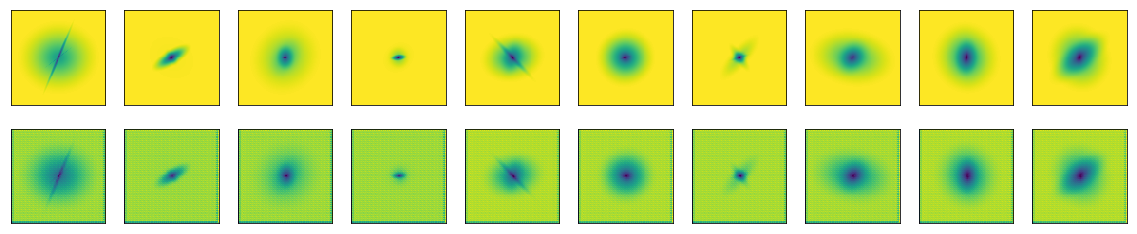

In [9]:
#teste a predição com os variogramas de teste
decoded_imgs = autoencoder.predict( testVariograms )

nFigs = 10
plt.figure(figsize=(20, 4))
for i in range(nFigs):
    # display original
    ax = plt.subplot(2, nFigs, i+1)
    plt.imshow(testVariograms[i].reshape(getGridParameters().NI, getGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, nFigs, i + nFigs + 1)
    plt.imshow(decoded_imgs[i].reshape(getGridParameters().NI, getGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Tenta fazer a reconstituição para o variograma experimental

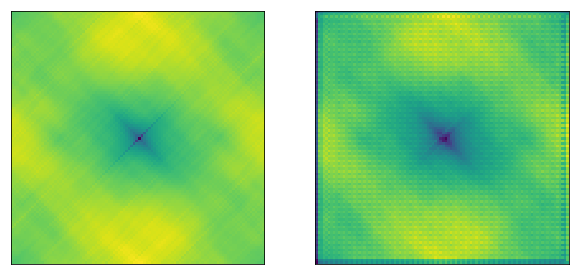

In [10]:
#rearranja a imagem do varmap experimental para uma dimensionalidade esperada pelo Keras:
#1ª dimensao: número de imagens (no caso soh uma)
#dimensões do meio: dimensões de cada imagem
#última dimensão: número de canais por imagem (no caso soh uma) para imagens muiltiespectrais ou RGB esse valor pode variar
if( len(experimentalVarmap.shape) < 4 ) :
    experimentalVarmap = experimentalVarmap.reshape((1,) + experimentalVarmap.shape + (1,))
    
#reconstituir o variograma experimental
decoded_img = autoencoder.predict( experimentalVarmap )

f, axarr = plt.subplots(1,2,figsize=(10, 10))
axarr[0].imshow(experimentalVarmap.reshape(getGridParameters().NI, getGridParameters().NJ))
axarr[0].get_xaxis().set_visible(False)
axarr[0].get_yaxis().set_visible(False)
axarr[1].imshow(decoded_img.reshape(getGridParameters().NI, getGridParameters().NJ))
axarr[1].get_xaxis().set_visible(False)
axarr[1].get_yaxis().set_visible(False)

plt.show()

Cria uma nova rede, conectando uma MLP à saída da parte convolutiva da rede U.

In [11]:
# Faz uma cópia da rede U
autoencoder_copy= keras.models.clone_model( autoencoder )
autoencoder_copy.build((None, getGridParameters().NI * getGridParameters().NJ)) # numero de variaveis na camada de entrada (input layer)
autoencoder_copy.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder_copy.set_weights( autoencoder.get_weights() )

# Remover da rede U toda a parte decodificadora.
# ATENÇÃO: se modificar o número de camadas na parte decodificadora, é necessário
#          mudar o range do loop abaixo.
for i in range ( 1, 15 ) :
   autoencoder_copy.layers.pop()
   autoencoder_copy.layers[-1].outbound_nodes = []
   autoencoder_copy.outputs = [autoencoder_copy.layers[-1].output]

# Marcar as camadas atuais (já treinadas) como não treináveis (preservar os pesos aprendidos)
# para que apenas a parte MLP seja treinada.
for layer in autoencoder_copy.layers[:] :
    layer.trainable = False
autoencoder_copy.compile(optimizer='adadelta', loss='binary_crossentropy')

#Monta a parte MLP da futura rede.
mlp = autoencoder_copy.layers[-1].output
mlp = Flatten()( mlp )
mlp = Dense( 5000, activation='relu' )( mlp ) 
mlp = Dense( 2000, activation='relu' )( mlp ) 
mlp = Dense( 500, activation='relu' )( mlp ) 
mlp = Dense( 100, activation='relu' )( mlp ) 
mlp = Dense( 50, activation='relu' )( mlp ) 
mlp = Dense( totalNumberOfParameters, activation='linear' )( mlp ) 

#Monta uma CNN composta pela parte convolutiva da rede U conectada
#a uma MLP
cnn_mlp = Model( autoencoder_copy.input, mlp )
cnn_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 10)      100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 20)        1820      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 40)        7240      
__________

Treina a nova rede (somente a parte neuronial).

In [12]:
#compila o modelo, passando o algoritmo de otimização, a métrica para a função-objetivo e a métrica para aferir a acurácia
cnn_mlp.compile(optimizer=keras.optimizers.Adam(), 
                loss="mean_squared_error") #metrics=["accuracy"] não ajuda para regressões

#Compatibiliza as variáveis de resposta (parâmetros variográficos) para uso no Keras
# Remover o ultimo elemento da tupla que representa a dimensionalidade do tensor das varíaveis de resposta
my_list = list(testParameters.shape)
nJ = my_list.pop(-1) #sei que última dimensão é 1
if nJ == 1 :
    testParameters = testParameters.reshape( tuple(my_list) )
my_list = list(trainParameters.shape)
nJ = my_list.pop(-1) #sei que última dimensão é 1
if nJ == 1 :
    trainParameters = trainParameters.reshape( tuple(my_list) )

#treina a rede
#20% do dado de entrada serão usados como conjunto de validação, ou seja, a cada passo (época),
#a função-objetivo é avaliada usando esses dados
#run_hist = model.fit(X, y, validation_split=0.15, epochs=20)
cnn_mlp.fit(trainVariograms, trainParameters, 
                     validation_data=(testVariograms, testParameters), 
                     epochs=20)

Train on 30 samples, validate on 10 samples
Epoch 1/20
30/30 [==============================] - 3s 94ms/step - loss: 0.1882 - val_loss: 0.1558
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1490 - val_loss: 0.2267
Epoch 3/20
30/30 [==============================] - 1s 24ms/step - loss: 0.2141 - val_loss: 0.1070
Epoch 4/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0939 - val_loss: 0.1221
Epoch 5/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1113 - val_loss: 0.1027
Epoch 6/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0873 - val_loss: 0.0875
Epoch 7/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0730 - val_loss: 0.0838
Epoch 8/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0746 - val_loss: 0.0724
Epoch 9/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0652 - val_loss: 0.0750
Epoch 10/20
30/30 [==============================] - 1s 24ms/step

In [13]:
#rearranja a imagem do varmap experimental para uma dimensionalidade esperada pelo Keras:
#1ª dimensao: número de imagens (no caso soh uma)
#dimensões do meio: dimensões de cada imagem
#última dimensão: número de canais por imagem (no caso soh uma) para imagens muiltiespectrais ou RGB esse valor pode variar
if( len(experimentalVarmap.shape) < 4 ) :
    experimentalVarmap = experimentalVarmap.reshape((1,) + experimentalVarmap.shape + (1,))
    
#realiza a regressão (predição)
y_pred  = cnn_mlp.predict(experimentalVarmap)

[[0.45500153 0.44757837 0.3439135  0.19263735]
 [0.4656145  0.48391005 0.3348039  0.28074187]
 [0.57287437 0.4684234  0.25174552 0.30182484]
 [0.59269977 0.55009985 0.22619544 0.33591196]]


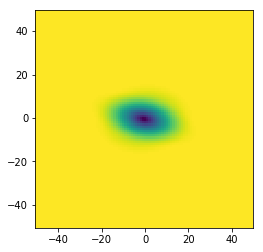

In [14]:
print(y_pred[0].reshape((4,4)))

#converte array de float32 retornado pelo Keras para array de float64 para poder chamar a funcao compilada
lala = np.zeros(( totalNumberOfParameters, 1))
lala[:,:] = y_pred.reshape((totalNumberOfParameters, 1)) 

#de-unitize the predicted parameters to generate the variogram model surface
for i in range( numberOfNestedStructures ) :
    lala[i * numberOfParametersPerNestedStructure]     = lala[i * numberOfParametersPerNestedStructure]     * 180;
    lala[i * numberOfParametersPerNestedStructure + 1] = lala[i * numberOfParametersPerNestedStructure + 1] * maxAxis;
    lala[i * numberOfParametersPerNestedStructure + 2] = lala[i * numberOfParametersPerNestedStructure + 2] * maxAxis;
    lala[i * numberOfParametersPerNestedStructure + 3] = lala[i * numberOfParametersPerNestedStructure + 3] * sill;
variogramModelSurface = makeVariogramModelSurface( lala );

#plota o modelo variografico obtido
plt.imshow( variogramModelSurface, interpolation='none', extent=getExtent2D( getGridParameters() ))